In [308]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as st
from scipy.stats import linregress

In [309]:
#Combining all datasets for 
path = '../Data/Natural Disaster Data'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

#Create a dataframe based on multiple csvs
natural_disasters_df = pd.concat(li, axis=0, ignore_index=True)
natural_disasters_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,195004,28,1445,195004,28,1445,NaN,10096222,OKLAHOMA,40.0,...,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB
1,195004,29,1530,195004,29,1530,NaN,10120412,TEXAS,48.0,...,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB
2,195007,5,1800,195007,5,1800,NaN,10104927,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB
3,195007,5,1830,195007,5,1830,NaN,10104928,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB
4,195007,24,1440,195007,24,1440,NaN,10104929,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB


In [310]:
#Cleaning the Dataframe created above
natural_disasters_df = natural_disasters_df.drop(columns =['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY','END_TIME','EPISODE_ID','STATE_FIPS','CZ_TYPE','CZ_FIPS','CZ_NAME','WFO','BEGIN_DATE_TIME','CZ_TIMEZONE','END_DATE_TIME','SOURCE','MAGNITUDE_TYPE','FLOOD_CAUSE','CATEGORY','TOR_F_SCALE','TOR_LENGTH','TOR_WIDTH','TOR_OTHER_WFO','TOR_OTHER_CZ_STATE','TOR_OTHER_CZ_FIPS','TOR_OTHER_CZ_NAME','BEGIN_RANGE','BEGIN_AZIMUTH','BEGIN_LOCATION','END_RANGE','END_AZIMUTH','END_LOCATION','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON','EPISODE_NARRATIVE','EVENT_NARRATIVE'])

In [311]:
# Check to see if there are any rows with missing data
natural_disasters_df['DAMAGE_CROPS'] = natural_disasters_df['DAMAGE_CROPS'].fillna(0)
natural_disasters_df['DAMAGE_PROPERTY'] = natural_disasters_df['DAMAGE_PROPERTY'].fillna(0)

In [312]:
#This cleans the financial impact data and allows us to preform calculations

#Take the K M B identifiers off of DAMAGE_PROPERTY
natural_disasters_df['property_money_identifier'] = natural_disasters_df.DAMAGE_PROPERTY.str.extract(r'[\d\.]+([KkMBHhT]+)', expand=False)
natural_disasters_df['DAMAGE_PROPERTY'] = natural_disasters_df['DAMAGE_PROPERTY'].str.replace(r'[KkMBHhT?]+$','', regex=True)

#Take the K M B identifiers off of DAMAGE_CROPS
natural_disasters_df['crops_money_identifier'] = natural_disasters_df.DAMAGE_CROPS.str.extract(r'[\d\.]+([KkMBHhT]+)', expand=False)
natural_disasters_df['DAMAGE_CROPS'] = natural_disasters_df['DAMAGE_CROPS'].str.replace(r'[KkMBHh?T]+$','', regex=True)

#Replace K M and B with values in money_identifier with the values in the property_money_identifier column
natural_disasters_df['property_money_identifier'] = natural_disasters_df['property_money_identifier'].str.replace(r'[Kk]+$','1000', regex=True)
natural_disasters_df['property_money_identifier'] = natural_disasters_df['property_money_identifier'].str.replace(r'[M]+$','1000000', regex=True)
natural_disasters_df['property_money_identifier'] = natural_disasters_df['property_money_identifier'].str.replace(r'[B]+$','1000000000', regex=True)
natural_disasters_df['property_money_identifier'] = natural_disasters_df['property_money_identifier'].str.replace(r'[T]+$','1000000000000', regex=True)
natural_disasters_df['property_money_identifier'] = natural_disasters_df['property_money_identifier'].str.replace(r'[hH?]+$','1', regex=True)
natural_disasters_df['property_money_identifier'] = natural_disasters_df['property_money_identifier'].fillna(1)

#Replace K M and B with values in money_identifier with the values in the property_money_identifier column
natural_disasters_df['crops_money_identifier'] = natural_disasters_df['crops_money_identifier'].str.replace(r'[Kk]+$','1000', regex=True)
natural_disasters_df['crops_money_identifier'] = natural_disasters_df['crops_money_identifier'].str.replace(r'[M]+$','1000000', regex=True)
natural_disasters_df['crops_money_identifier'] = natural_disasters_df['crops_money_identifier'].str.replace(r'[B]+$','1000000000', regex=True)
natural_disasters_df['crops_money_identifier'] = natural_disasters_df['crops_money_identifier'].str.replace(r'[T]+$','1000000000000', regex=True)
natural_disasters_df['crops_money_identifier'] = natural_disasters_df['crops_money_identifier'].str.replace(r'[hH?]+$','1', regex=True)
natural_disasters_df['crops_money_identifier'] = natural_disasters_df['crops_money_identifier'].fillna(1)


In [313]:
# Replace any '' with a zero
natural_disasters_df['DAMAGE_CROPS'] = natural_disasters_df['DAMAGE_CROPS'].fillna(0)
natural_disasters_df['DAMAGE_PROPERTY'] = natural_disasters_df['DAMAGE_PROPERTY'].fillna(0)

# Convert DAMAGE_PROPERTY & DAMAGE_CROPS
natural_disasters_df['DAMAGE_PROPERTY'] = pd.to_numeric(natural_disasters_df['DAMAGE_PROPERTY'])
natural_disasters_df['DAMAGE_CROPS'] = pd.to_numeric(natural_disasters_df['DAMAGE_CROPS'])
natural_disasters_df['crops_money_identifier'] = pd.to_numeric(natural_disasters_df['crops_money_identifier'])
natural_disasters_df['property_money_identifier'] = pd.to_numeric(natural_disasters_df['property_money_identifier'])

# Multiply 'DAMAGE_PROPERTY' by 'property_money_identifier' & multiply 'DAMAGE_CROPS' by 'crops_money_identifier'
natural_disasters_df['DAMAGE_PROPERTY'] = natural_disasters_df['DAMAGE_PROPERTY'] * natural_disasters_df['property_money_identifier']
natural_disasters_df['DAMAGE_CROPS'] = natural_disasters_df['DAMAGE_CROPS'] * natural_disasters_df['crops_money_identifier']

In [314]:
#Drop rows that have no monetary value for "DAMAGE_PROPERTY" or "DAMAGE_CROPS"
natural_disasters_df = natural_disasters_df.loc[(natural_disasters_df['DAMAGE_PROPERTY'] !=0) | (natural_disasters_df['DAMAGE_CROPS'] !=0)]

#Drop columns that will not be referenced in the future 'property_money_identifier' & 'crops_money_identifier'
natural_disasters_df = natural_disasters_df.drop(columns =['property_money_identifier','crops_money_identifier'])
natural_disasters_df.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,DATA_SOURCE
0,10096222,OKLAHOMA,1950,April,Tornado,0,0,0,0,250000.0,0.0,0.0,PUB
1,10120412,TEXAS,1950,April,Tornado,0,0,0,0,25000.0,0.0,0.0,PUB
2,10104927,PENNSYLVANIA,1950,July,Tornado,2,0,0,0,25000.0,0.0,0.0,PUB
3,10104928,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2500.0,0.0,0.0,PUB
4,10104929,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2500.0,0.0,0.0,PUB


In [315]:
# Commonizing Thunderstorm callouts in the file so we can complete a groupby
no_thunderstom_X = natural_disasters_df.replace({'THUNDERSTORM WINDS LIGHTNING':"Thunderstorm",'THUNDERSTORM WINDS/FLOODING':"Thunderstorm",'THUNDERSTORM WINDS/ FLOOD':"Thunderstorm",'Thunderstorm Wind':"Thunderstorm",'Marine Thunderstorm Wind':"Thunderstorm",'Lightning':"Thunderstorm",'Marine Hail': "Thunderstorm",'THUNDERSTORM WIND/ TREE ':"Thunderstorm"})

In [316]:
#Import Inflation Data to adjust "DAMAGE_PROPERTY" and "DAMAGE_CROPS"
CPI = '../Data/CPIdata1950-2020.csv'
CPI_df = pd.read_csv(CPI)
CPI_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,1950,23.5,23.5,23.6,23.6,23.7,23.8,24.1,24.3,24.4,24.6,24.7,25.0,24.1,NaN,NaN
1,1951,25.4,25.7,25.8,25.8,25.9,25.9,25.9,25.9,26.1,26.2,26.4,26.5,26.0,NaN,NaN
2,1952,26.5,26.3,26.3,26.4,26.4,26.5,26.7,26.7,26.7,26.7,26.7,26.7,26.5,NaN,NaN
3,1953,26.6,26.5,26.6,26.6,26.7,26.8,26.8,26.9,26.9,27.0,26.9,26.9,26.7,NaN,NaN
4,1954,26.9,26.9,26.9,26.8,26.9,26.9,26.9,26.9,26.8,26.8,26.8,26.7,26.9,NaN,NaN


In [317]:
# Create index multiplier for each year
CPI_df['CPI_Multiplier'] = CPI_df['Annual'].iloc[-2] / CPI_df['Annual']

In [318]:
# Drop unecessary rows in the inflation dataframe
clean_cpi = CPI_df.drop(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Annual','HALF1','HALF2'], axis=1)
clean_cpi.rename(columns={'Year':'YEAR'},inplace=True)
clean_cpi.head()

,YEAR,CPI_Multiplier
0,1950,10.608174
1,1951,9.832962
2,1952,9.647434
3,1953,9.575169
4,1954,9.503978


In [319]:
# Multiply 'DAMAGE_PROPERTY' by 'CPI_Multiplier' & multiply 'DAMAGE_CROPS' by 'CPI_Multiplier' after merge
natural_disasters_df = natural_disasters_df.merge(clean_cpi)
natural_disasters_df['DAMAGE_PROPERTY'] = natural_disasters_df['DAMAGE_PROPERTY'] * natural_disasters_df['CPI_Multiplier']
natural_disasters_df['DAMAGE_CROPS'] = natural_disasters_df['DAMAGE_CROPS'] * natural_disasters_df['CPI_Multiplier']

In [320]:
# Write the cleaned natural disaster data to a CSV file
natural_disasters_df.to_csv("../Data/natural_disasters.csv")

In [321]:
# Creating 2 different dataframes for ['Tornado','Thunderstorm','Hail'] and events that were added after 1993
array = ['Tornado','Thunderstorm','Hail']
ttwh_df = natural_disasters_df.loc[natural_disasters_df['EVENT_TYPE'].isin(array)]
ninety_six_df = natural_disasters_df.loc[natural_disasters_df['EVENT_TYPE'].isin(array) == False]
ttwh_df.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,DATA_SOURCE,CPI_Multiplier
0,10096222,OKLAHOMA,1950,April,Tornado,0,0,0,0,2.652044e+06,0.0,0.0,PUB,10.608174
1,10120412,TEXAS,1950,April,Tornado,0,0,0,0,2.652044e+05,0.0,0.0,PUB,10.608174
2,10104927,PENNSYLVANIA,1950,July,Tornado,2,0,0,0,2.652044e+05,0.0,0.0,PUB,10.608174
3,10104928,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2.652044e+04,0.0,0.0,PUB,10.608174
4,10104929,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2.652044e+04,0.0,0.0,PUB,10.608174


In [322]:
# Create a yearly DF for Tornado Thunderstorms and Hail
yearly_df = ttwh_df.groupby(by=['YEAR']).sum()
yearly_df.head()

,EVENT_ID,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,CPI_Multiplier
YEAR,,,,,,,,,
1950,1960689441,642,0,67,0,3.657874e+08,0.0,0.0,2068.593983
1951,2312729757,485,0,33,0,6.441179e+08,0.0,0.0,2261.581154
1952,2272639726,1885,0,231,0,9.097746e+08,0.0,0.0,2180.320075
1953,4063385263,4708,0,498,0,5.707803e+09,0.0,0.0,3868.368090
1954,4846357874,681,0,36,0,8.154918e+08,0.0,0.0,4580.917249


In [323]:
# Create a yearly DF for Tornado Thunderstorms and Hail
yearly_df2 = ninety_six_df.groupby(by=['YEAR']).sum()
yearly_df2.head()

,EVENT_ID,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,CPI_Multiplier
YEAR,,,,,,,,,
1993,25600531642,142,0,34,0,3.608652e+09,1.914650e+07,23516.00,4382.438678
1994,52238765290,251,0,7,0,1.164016e+09,2.118820e+08,57221.00,8720.284312
1995,55770574921,412,0,31,0,3.259025e+09,2.072280e+08,39268.00,9052.002441
1996,54174318270,1107,0,163,0,7.653020e+09,2.510025e+09,116394.03,15875.501281
1997,53899175199,1411,0,163,0,1.340866e+10,1.508817e+09,113291.00,15312.341065


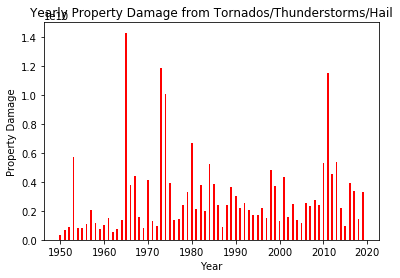

In [324]:
years = yearly_df.index.array
pdamage = yearly_df.DAMAGE_PROPERTY.array
cdamage = yearly_df.DAMAGE_CROPS.array

plt.bar(years, pdamage ,color="red", width=0.4)

plt.xlabel("Year") 
plt.ylabel("Property Damage") 
plt.title("Yearly Property Damage from Tornados/Thunderstorms/Hail") 
plt.show() 

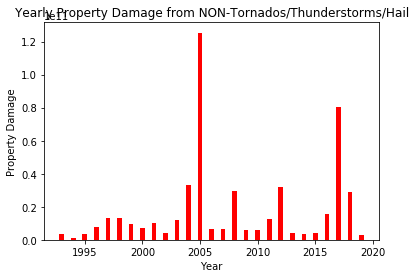

In [325]:
years2 = yearly_df2.index.array
pdamage2 = yearly_df2.DAMAGE_PROPERTY.array
cdamage2 = yearly_df2.DAMAGE_CROPS.array

plt.bar(years2, pdamage2 ,color="red", width=0.4)

plt.xlabel("Year") 
plt.ylabel("Property Damage") 
plt.title("Yearly Property Damage from NON-Tornados/Thunderstorms/Hail") 
plt.show() 

In [326]:
x_axis = years
y_axis = yearly_df['DAMAGE_PROPERTY']


# Calculate the correlation coefficient and linear regression model 
corr_coef = st.pearsonr(x_axis, y_axis)
round_corr = round(corr_coef[0],3)
round_corr
# Linear Regression Modeling
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.title("Property Damage of Tornados/Thunderstorms/Hurricanes")

plt.annotate(line_eq,(1955,4000000000),fontsize=10,color="red")
plt.xlabel("Years")
plt.ylabel("Property Damage ($)")
plt.scatter(x_axis,y_axis)
plt.plot(years,regress_values,"r-")
plt.ylim(0,7000000000)
plt.xlim(1950,2020)
plt.show()

ValueError: PandasArray must be 1-dimensional.

In [327]:
#This ends beds Project1-BS file


In [328]:
#This begins the JZwork file

In [329]:
data = '../Data/natural_disasters.csv'
clean_df = pd.read_csv(data)
clean_df.head()

,Unnamed: 0,EVENT_ID,STATE,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,DATA_SOURCE,CPI_Multiplier
0,0,10096222,OKLAHOMA,1950,April,Tornado,0,0,0,0,2.652044e+06,0.0,0.0,PUB,10.608174
1,1,10120412,TEXAS,1950,April,Tornado,0,0,0,0,2.652044e+05,0.0,0.0,PUB,10.608174
2,2,10104927,PENNSYLVANIA,1950,July,Tornado,2,0,0,0,2.652044e+05,0.0,0.0,PUB,10.608174
3,3,10104928,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2.652044e+04,0.0,0.0,PUB,10.608174
4,4,10104929,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2.652044e+04,0.0,0.0,PUB,10.608174


In [330]:
year_df = clean_df.groupby('YEAR')
#year_df.head()
year_events = year_df['EVENT_TYPE'].count()
year_ttl_dmg = year_df['DAMAGE_PROPERTY'].sum()
year_ttl_dmg

YEAR
1950    3.657874e+08
1951    6.441179e+08
1952    9.097746e+08
1953    5.707803e+09
1954    8.154918e+08
            ...     
2015    4.796384e+09
2016    1.940700e+10
2017    8.385876e+10
2018    3.044750e+10
2019    6.243334e+09
Name: DAMAGE_PROPERTY, Length: 70, dtype: float64

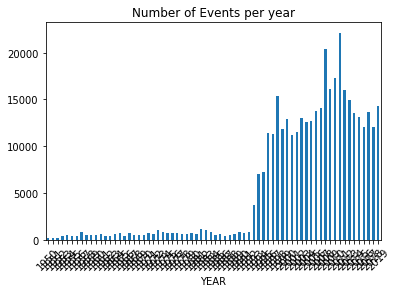

In [331]:
#This displays the number of Natural Disasters each year
event_chart = year_events.plot(kind='bar', title="Number of Events per year",)
plt.xticks(rotation=45)
plt.show()

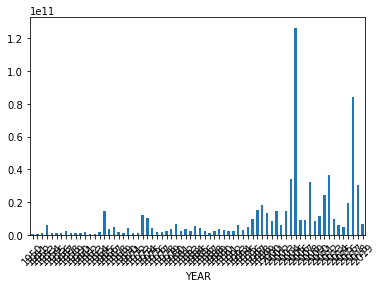

In [332]:
#This graph shows the amount of Natural disaster per category
ttl_dmg_chart = year_ttl_dmg.plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

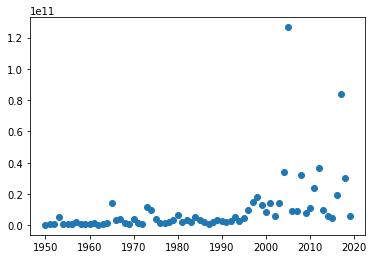

In [333]:
#This graph shows the damage created each year
y_axis = year_df['DAMAGE_PROPERTY'].sum()
x_axis = year_df['YEAR'].unique()
plt.scatter(x_axis,y_axis)
plt.show()

In [334]:
array = ['Tornado','Thunderstorm','Hail']
ttwh_df = no_thunderstom_X.loc[no_thunderstom_X['EVENT_TYPE'].isin(array)]
ninety_six_df = no_thunderstom_X.loc[no_thunderstom_X['EVENT_TYPE'].isin(array) == False]
ttwh_df.head()

,EVENT_ID,STATE,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,DATA_SOURCE
0,10096222,OKLAHOMA,1950,April,Tornado,0,0,0,0,250000.0,0.0,0.0,PUB
1,10120412,TEXAS,1950,April,Tornado,0,0,0,0,25000.0,0.0,0.0,PUB
2,10104927,PENNSYLVANIA,1950,July,Tornado,2,0,0,0,25000.0,0.0,0.0,PUB
3,10104928,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2500.0,0.0,0.0,PUB
4,10104929,PENNSYLVANIA,1950,July,Tornado,0,0,0,0,2500.0,0.0,0.0,PUB


In [335]:
years_df = ttwh_df.groupby('YEAR')
#year_df.head()
years_events = years_df['EVENT_TYPE'].count()
years_ttl_dmg = years_df['DAMAGE_PROPERTY'].sum()
years_ttl_dmg

YEAR
1950    3.448165e+07
1951    6.550599e+07
1952    9.430224e+07
1953    5.961047e+08
1954    8.580532e+07
            ...     
2015    1.172718e+09
2016    3.866278e+09
2017    3.508485e+09
2018    1.548634e+09
2019    3.482174e+09
Name: DAMAGE_PROPERTY, Length: 70, dtype: float64

In [336]:
#This creates a data file for Cost per Incident
CPI = '../Data/CPIdata1950-2020.csv'
CPI_df = pd.read_csv(CPI)
CPI_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,1950,23.5,23.5,23.6,23.6,23.7,23.8,24.1,24.3,24.4,24.6,24.7,25.0,24.1,NaN,NaN
1,1951,25.4,25.7,25.8,25.8,25.9,25.9,25.9,25.9,26.1,26.2,26.4,26.5,26.0,NaN,NaN
2,1952,26.5,26.3,26.3,26.4,26.4,26.5,26.7,26.7,26.7,26.7,26.7,26.7,26.5,NaN,NaN
3,1953,26.6,26.5,26.6,26.6,26.7,26.8,26.8,26.9,26.9,27.0,26.9,26.9,26.7,NaN,NaN
4,1954,26.9,26.9,26.9,26.8,26.9,26.9,26.9,26.9,26.8,26.8,26.8,26.7,26.9,NaN,NaN


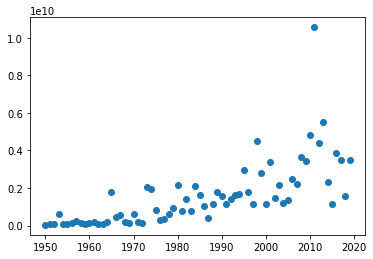

In [337]:
# This graphs damaged property each year
y_axis = years_df['DAMAGE_PROPERTY'].sum()
x_axis = ttwh_df['YEAR'].unique()
plt.scatter(x_axis,y_axis)
plt.show()

In [338]:
ttwh_df['DAMAGE_PROPERTY'] =ttwh_df.apply(lambda x: cpi.inflate(x.DAMAGE_PROPERTY, x.YEAR), axis=1)
df.head()

NameError: name 'cpi' is not defined

In [339]:
#This is the end of Jons JZwork file

In [340]:
#This is the begging of the USemssions file

In [341]:
emissions_data_path = "../Data/CO2Data.csv"
pop_data_path = "../Data/pop_data.csv"
emissions_df = pd.read_csv(emissions_data_path)
pop_df = pd.read_csv(pop_data_path)

In [342]:
us_co2_series = emissions_df.loc[249]
us_co2_df = us_co2_series.to_frame()
us_clean_df = us_co2_df.drop(['Country Name', 'Country Code','Indicator Name','Indicator Code', '2017', '2018','2019'])
us_clean_df['Year'] = us_clean_df.index
us_em_df = us_clean_df.rename(columns={249:"Metric ton per Capita Emissions"})
us_em_df = us_em_df[['Year', 'Metric ton per Capita Emissions']]
us_em_df.head()

,Year,Metric ton per Capita Emissions
1960,1960,15.9998
1961,1961,15.6813
1962,1962,16.0139
1963,1963,16.4828
1964,1964,16.9681


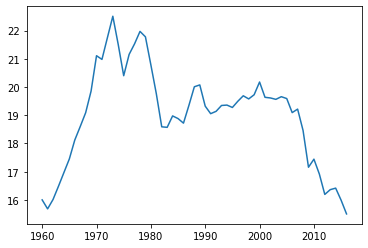

In [343]:
us_emission_line = us_em_df.plot.line(legend=None)

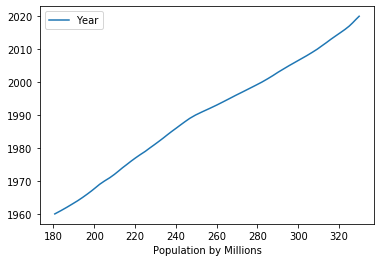

In [344]:
us_pop_line = pop_df.plot.line(x='Population by Millions', y='Year')

In [345]:
merged_data = pop_df.merge(us_em_df)
merged_data.head()

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [346]:
merged_data = merged_data.rename(columns={'Population by Millions':"pop", 'Metric ton per Capita Emissions':'emissions'})
merged_data.dtypes
merged_data['US Total Emmissions'] = merged_data['pop'] * merged_data['emissions']
merged_data.head()

NameError: name 'merged_data' is not defined

In [347]:
x = merged_data['Year']
y = merged_data['US Total Emmissions']
us_total_emissions_line = merged_data.plot.line(x='Year', y='US Total Emmissions')
plt.savefig("Images/UsEmissionsTrend.png")
plt.show()

NameError: name 'merged_data' is not defined

In [348]:
final_csv_location = "../Data/Year_CO2_Pop_data.csv"
merged_data.to_csv(final_csv_location)

NameError: name 'merged_data' is not defined

In [349]:
#This completed the USemissions file

In [350]:
#This begins the inflation file

In [351]:
CPI = '../Data/CPIdata1950-2020.csv'
CPI_df = pd.read_csv(CPI)
CPI_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,1950,23.5,23.5,23.6,23.6,23.7,23.8,24.1,24.3,24.4,24.6,24.7,25.0,24.1,NaN,NaN
1,1951,25.4,25.7,25.8,25.8,25.9,25.9,25.9,25.9,26.1,26.2,26.4,26.5,26.0,NaN,NaN
2,1952,26.5,26.3,26.3,26.4,26.4,26.5,26.7,26.7,26.7,26.7,26.7,26.7,26.5,NaN,NaN
3,1953,26.6,26.5,26.6,26.6,26.7,26.8,26.8,26.9,26.9,27.0,26.9,26.9,26.7,NaN,NaN
4,1954,26.9,26.9,26.9,26.8,26.9,26.9,26.9,26.9,26.8,26.8,26.8,26.7,26.9,NaN,NaN


In [352]:
# create index multiplier
CPI_df['CPI_Multiplier'] = CPI_df['Annual'].iloc[-2] / CPI_df['Annual']

In [353]:
clean_cpi = CPI_df.drop(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Annual','HALF1','HALF2'], axis=1)

In [354]:
clean_cpi = clean_cpi.drop(index=70)

In [355]:
clean_cpi.to_csv('clean_cpi.csv', index=False)

In [356]:
#This completes the inflation file